# Deep Learning in Business (Telco)

The purpose of this notebook is to present the use of deep learning and especially convolution network and embedding with business data that includes transactions, categorical characteristcs of customers.
Through this post, we want to show that deep learning is a very efficient and practical technique especially through functional API to handle the different types of business data associated to use cases such as churn, product recommendation, behavior segmentation or even business forecasts.

Convolutional network have proven very useful to handle multi-dimensional temporal data, embeddings enable to represent meaningfully and automatically categorical attributes or sequence of attributes that were not considered in traditional predictive models. <br>
Hence, in addition of the effectiveness of the deep learning techniques, those enable the business analyst to reduce the human bias to consider one variables rather than another in interpreting the behavior of a customer. Indeed, instead of considering variables created with business knowledge and bias such as average data usage, max of call duration in the last week, flag for VIP plan, the model will consider raw or semi-raw data, will consume them and derive itself the features learned while trying to predict a quantity. <br> 
By not considering the model as a black-box, by thoroughly interpreting and visualizing the intermediate layers of the network, the business analyst would be able to actually discover customer signature that are driving churn for example. In this post, we attach a lot of important to visualizing the results of our network via the concept of the "behavior as a picture" and the results of our embeddings.

The notebook is composed of 4 parts:
- Convolutional network to predict churn with semi-transactional usage data considered as image
- How Convnet sees the churn or the usage behavior
- Plan embedding to predict churn
- Multi-branch and hybrid churn model

References: 

Churn analysis using convolutional network and autoencoders https://arxiv.org/abs/1604.05377

https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html

https://blog.keras.io/building-autoencoders-in-keras.html

## 0. Pre-requisites

In [3]:
from keras import backend as K
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape
from keras.layers import Input, concatenate, BatchNormalization
from keras.models import Model
from keras.layers.convolutional import Convolution2D, MaxPooling2D, UpSampling2D 
from keras.optimizers import SGD, RMSprop
from keras.utils import np_utils                                                                                                      
from keras.models import Sequential 


from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pylab as pl
import numpy as np
import math
import pandas as pd
from sklearn import metrics
from sklearn.manifold import TSNE
from mpl_toolkits.axes_grid1 import AxesGrid

import tensorflow as tf

%matplotlib inline

In [2]:
K.image_data_format()

'channels_last'

### Data Import

All the data is provided in a single table that is build around daily usage for a full month per subscriber. The 12 fields from #outgoing calls to Cost represents daily aggregate for 31 days (one line per SUBSCRIBER_ID and Date) prior a churn assessment window of one month. This assessed churn is given in the CHURN column and is repeated 31 times of each subscriber only for convenience.

The plan characteristic is the latest plan of each subscriber and is repeated 31 times only for table convenience.

In [6]:
# The code was removed by DSX for sharing.

In [9]:
from io import StringIO
import requests
import json
import pandas as pd

# This function accesses a file in your Object Storage. The definition contains your credentials.
# You might want to remove those credentials before you share your notebook.
def get_object_storage_file_with_credentials_8f8071a3ce1746d89c1630604ac3201f(container, filename):
    """This functions returns a StringIO object containing
    the file content from Bluemix Object Storage."""

    url1 = ''.join([credentials_1['auth_url'], '/v3/auth/tokens'])
    data = {'auth': {'identity': {'methods': ['password'],
            'password': {'user': {'name': credentials_1['username'],'domain': {'id': credentials_1['domain_id']},
            'password': credentials_1['password']}}}}}
    headers1 = {'Content-Type': 'application/json'}
    resp1 = requests.post(url=url1, data=json.dumps(data), headers=headers1)
    resp1_body = resp1.json()
    for e1 in resp1_body['token']['catalog']:
        if(e1['type']=='object-store'):
            for e2 in e1['endpoints']:
                        if(e2['interface']=='public'and e2['region']=='dallas'):
                            url2 = ''.join([e2['url'],'/', container, '/', filename])
    s_subject_token = resp1.headers['x-subject-token']
    headers2 = {'X-Auth-Token': s_subject_token, 'accept': 'application/json'}
    resp2 = requests.get(url=url2, headers=headers2)
    return StringIO(resp2.text)

X_train = pd.read_csv(get_object_storage_file_with_credentials_8f8071a3ce1746d89c1630604ac3201f('DeepLearningforBusiness', 'usage_data_train.csv'))
X_test = pd.read_csv(get_object_storage_file_with_credentials_8f8071a3ce1746d89c1630604ac3201f('DeepLearningforBusiness', 'usage_data_test.csv'))
X_test.head()

,SUBSCRIBER_ID,Date,CHURN_FLAG,Plan,# outgoing calls _normalized,# incoming calls _normalized,Sum duration incoming calls _normalized,Sum duration outgoing calls _normalized,Volume voice_normalized,Volume upload _normalized,Volume download_normalized,Duration data connection _normalized,# data connection _normalized,# MT SMS _normalized,# MO SMS _normalized,Cost_normalized
0,anon_S10001,2014-08-26,0,1,0.0,0.0,0.581818,0.0,0.0,0.0,0.0,0.265292,0.0,0.0,0.090670,0.0
1,anon_S10001,2014-08-27,0,1,0.0,0.0,0.290909,0.0,0.0,0.0,0.0,0.205503,0.0,0.0,0.106000,0.0
2,anon_S10001,2014-08-28,0,1,0.0,0.0,0.290909,0.0,0.0,0.0,0.0,0.305964,0.0,0.0,0.138628,0.0
3,anon_S10001,2014-08-29,0,1,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.658406,0.0,0.0,0.510277,0.0
4,anon_S10001,2014-08-30,0,1,0.0,0.0,0.254545,0.0,0.0,0.0,0.0,0.576213,0.0,0.0,0.028251,0.0


### Data Reshaping

As described above, the churn and the plan characteristics have only one value per subscriber. Hence, we can just aggregate through the max to obtain one row per subscriber.

In [10]:
Y_train = X_train.groupby(['SUBSCRIBER_ID'])['CHURN_FLAG'].agg({'CHURN':'max'})
Y_test = X_test.groupby(['SUBSCRIBER_ID'])['CHURN_FLAG'].agg({'CHURN':'max'}) 

Z_train = X_train.groupby(['SUBSCRIBER_ID'])['Plan'].agg({'Plan':'max'})
Z_test = X_test.groupby(['SUBSCRIBER_ID'])['Plan'].agg({'Plan':'max'})

Usage behavior as a picture: One multi-dimensional 31-day time series becomes one picture representing the usage behavior of one subscriber throughout the period of interest. Those pictures will be the input data to predict churn. As opposed to a traditional model where we would have had to take the average, max, min, slope across the 31 days, here we let the model decides which aggregation methods or representation of the time series is the most adapted to predict the churn.

We create the target as two classes (two variables) as it would be easier to generalize for more classes (softmax output) 

In [11]:
img_rows, img_cols = 31, 12

X_train = X_train.ix[:,4:16].values
Y_train = Y_train.ix[:,0:1].values
X_test = X_test.ix[:,4:16].values
Y_test = Y_test.ix[:,0:1].values

print('X_train shape:', X_train.shape)                                                      
print(X_train.shape[0], 'train days')                                                    
print(X_test.shape[0], 'test days') 

X_train = X_train.reshape(-1, img_rows, img_cols, 1)                          
X_test = X_test.reshape(-1, img_rows, img_cols, 1)                             
X_train = X_train.astype('float32')                                                         
X_test = X_test.astype('float32')                                                                                                                                  

print('X_train shape:', X_train.shape)                                                      
print(X_train.shape[0], 'train images')                                                    
print(X_test.shape[0], 'test images')  

Y_train = np_utils.to_categorical(Y_train, 2)                                      
Y_test = np_utils.to_categorical(Y_test, 2) 
print(Y_train.shape[0], 'train target images')                                                    
print(Y_test.shape[0], 'test target images')  


X_train shape: (298096, 12)
298096 train days
130262 test days
X_train shape: (9616, 31, 12, 1)
9616 train images
4202 test images
9616 train target images
4202 test target images


### Data Visualization as Picture

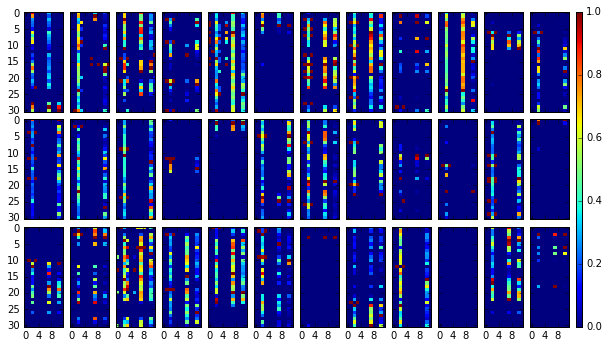

In [12]:
fig = plt.figure(1, (10, 10))
grid = AxesGrid(fig, 111, nrows_ncols=(3, 12), axes_pad=0.1, cbar_mode = 'single')
for i in range(36):
    im = grid[i].imshow(X_train[i,:,:,0],interpolation='nearest',cmap=None, vmin=0, vmax=1)
    grid.cbar_axes[i].colorbar(im)
    grid[i].set_xticks(np.arange(0, 12, 4))    
plt.show()

## 1. Convolutional network to predict churn
We are looking at 2 layer of convolutions, one considering 1 week of data together per variable (filter size 14,1) and the other considering all the variables together per aggregated time step (filter size 1,12). 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 31, 12, 1)         0         
_________________________________________________________________
batchnorm_usage (BatchNormal (None, 31, 12, 1)         48        
_________________________________________________________________
conv1 (Conv2D)               (None, 25, 12, 5)         40        
_________________________________________________________________
conv2 (Conv2D)               (None, 25, 1, 5)          305       
_________________________________________________________________
flatten_2 (Flatten)          (None, 125)               0         
_________________________________________________________________
dense1 (Dense)               (None, 5)                 630       
_________________________________________________________________
prediction (Dense)           (None, 2)                 12        
Total para

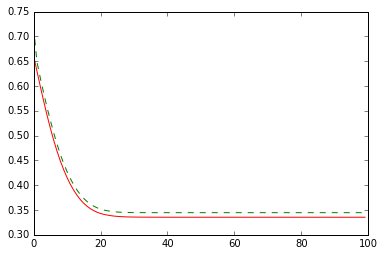

In [19]:
input_1 =  Input(shape=(31,12,1), name = "input_1")

x1 = BatchNormalization(axis=2,name="batchnorm_usage")(input_1)
x1 = Convolution2D(5, (7, 1), padding='valid', activation = 'relu', name = "conv1")(x1)
x1 = Convolution2D(5, (1, 12), padding='valid', activation = 'relu', name = "conv2")(x1)
x1 = Flatten()(x1)
x1 = Dense(5,activation = 'relu', name = "dense1")(x1)
prediction = Dense(2,activation = 'softmax', name = "prediction")(x1)


model = Model(inputs=input_1, outputs=prediction)
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adadelta',metrics=["accuracy"])                        

my_model = model.fit(X_train, Y_train, batch_size=100, epochs=100, verbose=0, validation_data=(X_test, Y_test))

#AUC Calculation
#s_test = model.predict(X_test, batch_size=10, verbose=0)[:,1]
#s_train = model.predict(X_train, batch_size=10, verbose=0)[:,1]
auc_test = metrics.roc_auc_score(Y_test[:,1], model.predict(X_test, batch_size=10, verbose=0)[:,1])
print('AUC test',auc_test)
auc_train = metrics.roc_auc_score(Y_train[:,1], model.predict(X_train, batch_size=10, verbose=0)[:,1])
print('AUC train',auc_train)

plt.plot(my_model.epoch, my_model.history['loss'], 'g--')
plt.plot(my_model.epoch, my_model.history['val_loss'], 'r-')

## 2. What is the network seeing?

In [20]:
def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)

def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    return x

In [21]:
#Choice of the layer
layer_output = model.get_layer("conv1").output

kept_filters = []
input_img_data1 = np.random.random((1, 31, 12,1))
input_img_data = input_img_data1

for i in range(0,5):
    #input_img_data = np.zeros(31*12).reshape(1,31,12,1)  
    input_img_data = input_img_data1
    loss = K.mean(layer_output[:, :, :, i])

    # we compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, input_1)[0]
    iterate = K.function([input_1], [loss, grads])

    step = 1

    for i in range(100):
            loss_value, grads_value = iterate([input_img_data])
            input_img_data += grads_value * step

            if loss_value <= 0.:
                # some filters get stuck to 0, we can skip them
                break


            # decode the resulting input image
    if loss_value > 0:
        print("yes")
        img = deprocess_image(input_img_data[0])
        kept_filters.append(img)

InvalidArgumentError: You must feed a value for placeholder tensor 'batchnorm_usage/keras_learning_phase' with dtype bool
	 [[Node: batchnorm_usage/keras_learning_phase = Placeholder[dtype=DT_BOOL, shape=[], _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'batchnorm_usage/keras_learning_phase', defined at:
  File "/usr/local/src/conda3_runtime/4.1.1/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/local/src/conda3_runtime/4.1.1/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/src/conda3_runtime/4.1.1/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/usr/local/src/conda3_runtime/4.1.1/lib/python3.5/site-packages/traitlets/config/application.py", line 596, in launch_instance
    app.start()
  File "/usr/local/src/conda3_runtime/4.1.1/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 442, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/src/conda3_runtime/4.1.1/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/src/conda3_runtime/4.1.1/lib/python3.5/site-packages/tornado/ioloop.py", line 883, in start
    handler_func(fd_obj, events)
  File "/usr/local/src/conda3_runtime/4.1.1/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/src/conda3_runtime/4.1.1/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/src/conda3_runtime/4.1.1/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/src/conda3_runtime/4.1.1/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/src/conda3_runtime/4.1.1/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/src/conda3_runtime/4.1.1/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/src/conda3_runtime/4.1.1/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/src/conda3_runtime/4.1.1/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 391, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/src/conda3_runtime/4.1.1/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 199, in do_execute
    shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/src/conda3_runtime/4.1.1/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2723, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/src/conda3_runtime/4.1.1/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2825, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/src/conda3_runtime/4.1.1/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2885, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-d8c9539c0b7d>", line 3, in <module>
    x1 = BatchNormalization(axis=2,name="batchnorm_usage")(input_1)
  File "/gpfs/fs01/user/s0f7-8d84ede00ef5c1-da7a39419701/.local/lib/python3.5/site-packages/keras/engine/topology.py", line 584, in __call__
    output = self.call(inputs, **kwargs)
  File "/gpfs/fs01/user/s0f7-8d84ede00ef5c1-da7a39419701/.local/lib/python3.5/site-packages/keras/layers/normalization.py", line 188, in call
    training=training)
  File "/gpfs/fs01/user/s0f7-8d84ede00ef5c1-da7a39419701/.local/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py", line 2461, in in_train_phase
    training = learning_phase()
  File "/gpfs/fs01/user/s0f7-8d84ede00ef5c1-da7a39419701/.local/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py", line 103, in learning_phase
    name='keras_learning_phase')
  File "/gpfs/fs01/user/s0f7-8d84ede00ef5c1-da7a39419701/.local/lib/python3.5/site-packages/tensorflow/python/ops/array_ops.py", line 1502, in placeholder
    name=name)
  File "/gpfs/fs01/user/s0f7-8d84ede00ef5c1-da7a39419701/.local/lib/python3.5/site-packages/tensorflow/python/ops/gen_array_ops.py", line 2149, in _placeholder
    name=name)
  File "/gpfs/fs01/user/s0f7-8d84ede00ef5c1-da7a39419701/.local/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 763, in apply_op
    op_def=op_def)
  File "/gpfs/fs01/user/s0f7-8d84ede00ef5c1-da7a39419701/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2327, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/gpfs/fs01/user/s0f7-8d84ede00ef5c1-da7a39419701/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1226, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'batchnorm_usage/keras_learning_phase' with dtype bool
	 [[Node: batchnorm_usage/keras_learning_phase = Placeholder[dtype=DT_BOOL, shape=[], _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


In [ ]:
C1 = np.squeeze(np.array(kept_filters[0:5]))
print(C1.shape)

fig = plt.figure(1, (10, 10))
grid = AxesGrid(fig, 111, nrows_ncols=(1, 5), axes_pad=0.1, cbar_mode = 'single')
for i in range(5):
    im = grid[i].imshow(C1[i,:,:],interpolation='nearest',cmap=None)
    grid.cbar_axes[i].colorbar(im)
    grid[i].set_xticks(np.arange(0, 12, 4))    
plt.show()

## 3. Embedding of plan variable

In [98]:
Z_train.Plan = pd.Categorical(Z_train.Plan)
Z_test.Plan = pd.Categorical(Z_test.Plan)

Z_train['index'] = Z_train.Plan.cat.codes
Z_test['index'] = Z_test.Plan.cat.codes

Plan_train = Z_train.ix[:,1:2].values
Plan_test = Z_test.ix[:,1:2].values

/usr/local/src/conda3_runtime/4.1.1/lib/python3.5/site-packages/ipykernel/__main__.py:9: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Softmax.0, inputs=/input_19)`


AUC test 0.631860116036
AUC train 0.748357632279


130.34675382793648

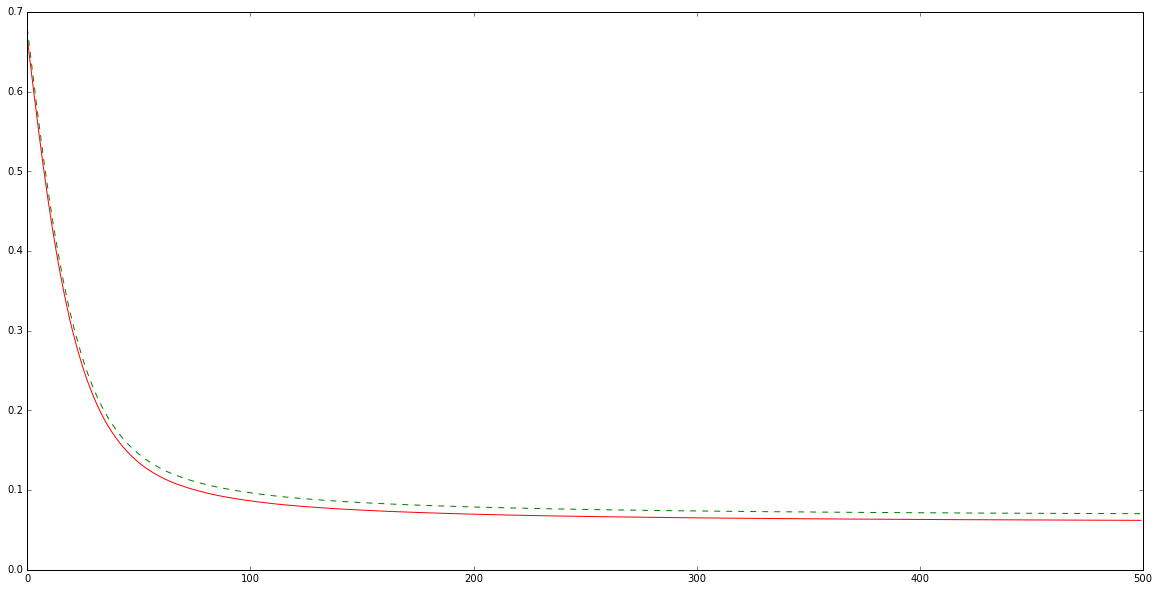

In [126]:
from keras.layers import Input, Embedding, Reshape, Dense
from keras.models import Model

input1 = Input(shape=(1,))
x = Embedding(input_dim=56,output_dim=2)(input1)
x = Reshape((2,),name="reshaped_embedding")(x)
prediction = Dense(2,activation='softmax',name='out',trainable=False)(x)

model = Model(input=input1, output=prediction)

model.compile(loss='binary_crossentropy', optimizer='adadelta',metrics=["accuracy"])
my_model = model.fit(Plan_train,Y_train,batch_size=10, epochs = 500, verbose=False, validation_data = (Plan_test, Y_test))


plt.plot(my_model.epoch, my_model.history['loss'], 'g--')
plt.plot(my_model.epoch, my_model.history['val_loss'], 'r-')

s_test = model.predict(Plan_test, batch_size=10, verbose=0)[:,1]
s_train = model.predict(Plan_train, batch_size=10, verbose=0)[:,1]
auc_test = metrics.roc_auc_score(Y_test[:,1], s_test)
print('AUC test',auc_test)
auc_train = metrics.roc_auc_score(Y_train[:,1], s_train)
print('AUC train',auc_train)
sum(s_train)


In [81]:
model.predict(Plan_test, batch_size=10, verbose=0)[:,1]

array([ 0.2132915,  0.2132915,  0.2132915, ...,  0.2132915,  0.2132915,
        0.2132915], dtype=float32)

/usr/local/src/conda3_runtime/4.1.1/lib/python3.5/site-packages/ipykernel/__main__.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{2}..., inputs=/input_19)`
  if __name__ == '__main__':


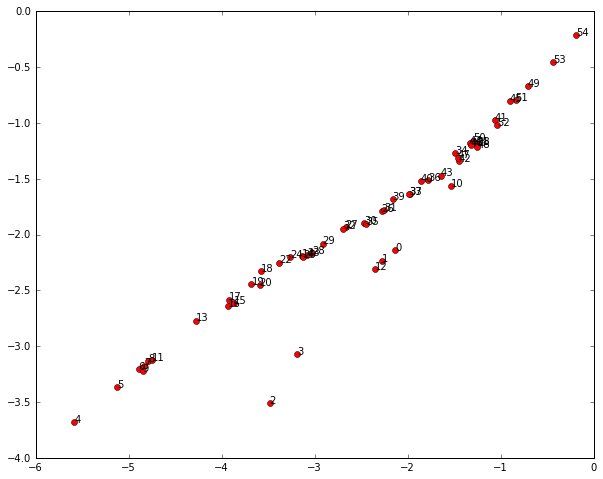

In [127]:
model_intermediary = Model(input=input1, output=model.get_layer("reshaped_embedding").output)

coords=pd.DataFrame(model_intermediary.predict(np.arange(55)))


fig, ax = plt.subplots(figsize=(10,8))
ax.plot(coords[0],coords[1],"ro")

for i, txt in enumerate(np.arange(55)):
    ax.annotate(i, (coords[0][i],coords[1][i]))

/usr/local/src/conda3_runtime/4.1.1/lib/python3.5/site-packages/ipykernel/__main__.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{2}..., inputs=/input_17)`
  if __name__ == '__main__':


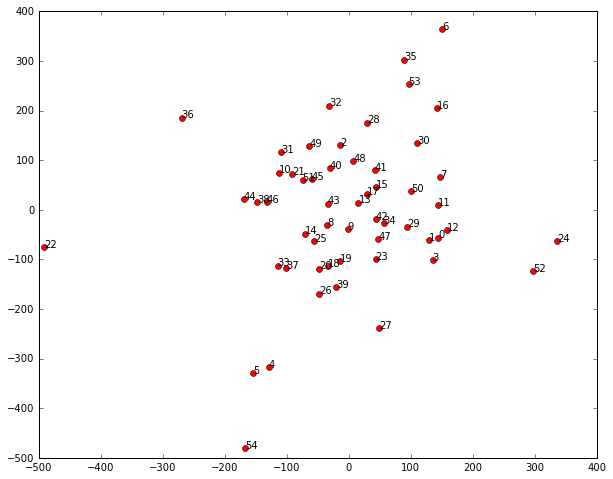

In [124]:
model_intermediary = Model(input=input1, output=model.get_layer("reshaped_embedding").output)

coords=pd.DataFrame(model_intermediary.predict(np.arange(55)))

model_tsne = TSNE(n_components=2, random_state=0,perplexity = 1)
X_2d = model_tsne.fit_transform(coords)


fig, ax = plt.subplots(figsize=(10,8))
ax.plot(X_2d[:,0],X_2d[:,1],"ro")

for i, txt in enumerate(np.arange(55)):
    ax.annotate(i, (X_2d[i,0],X_2d[i,1]))


## 4. Multi-branch network with CNN and Embedding

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 31, 12, 1)     0                                            
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 18, 12, 5)     75                                           
____________________________________________________________________________________________________
input_2 (InputLayer)             (None, 1)             0                                            
____________________________________________________________________________________________________
conv2 (Conv2D)                   (None, 18, 1, 5)      305                                          
___________________________________________________________________________________________

84.172211106919747

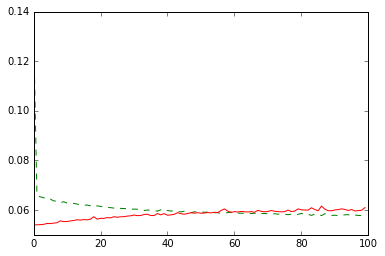

In [139]:
input_1 =  Input(shape=(31,12,1), name = "input_1")

x1 = Convolution2D(5, (14, 1), padding='valid',input_shape=(31, 12, 1), activation = 'relu', name = "conv1")(input_1)
x1 = Convolution2D(5, (1, 12), padding='valid',input_shape=(25,12,10), activation = 'relu', name = "conv2")(x1)
x1 = Flatten()(x1)
#x1 = Dense(5,activation = 'relu', name = "Usage")(x1)
#x1 = Dense(2,activation = 'softmax', name = "Dens2")(x1)

input_2 = Input(shape=(1,), name = "input_2")
x2 = Embedding(input_dim=56,output_dim=2)(input_2)
x2 = Reshape((2,),name="Plan_embedding")(x2)

x6 = concatenate([x1, x2], axis=1)
x6 = Dense(5, activation = 'relu')(x6)
prediction = Dense(2,activation = 'softmax', name = "prediction")(x6)


model = Model(inputs=[input_1,input_2], outputs=prediction)
model.summary()
model.compile(loss='binary_crossentropy', optimizer='adadelta',metrics=["accuracy"])
my_model = model.fit([X_train,Plan_train],Y_train,batch_size=10, epochs = 100, verbose=False, validation_data = ([X_test,Plan_test], Y_test))


plt.plot(my_model.epoch, my_model.history['loss'], 'g--')
plt.plot(my_model.epoch, my_model.history['val_loss'], 'r-')

s_test = model.predict([X_test,Plan_test], batch_size=10, verbose=0)[:,1]
s_train = model.predict([X_train,Plan_train], batch_size=10, verbose=0)[:,1]
auc_test = metrics.roc_auc_score(Y_test[:,1], s_test)
print('AUC test',auc_test)
auc_train = metrics.roc_auc_score(Y_train[:,1], s_train)
print('AUC train',auc_train)
sum(s_train)